In [1]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import dask
from IPython import display
import pandas as pd
import numpy as np
import geopandas as gpd

In [2]:
START_TIME = "2021-06-10 04:00"
END_TIME = "2021-06-10 21:00"

In [14]:
BASE_PATH = Path("/mnt/storage_ssd_8tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/")
SATELLITE_PATH = BASE_PATH / "satellite/EUMETSAT/SEVIRI_RSS/zarr/v3/eumetsat_seviri_hrv_uk.zarr"
NWP_PATH = BASE_PATH / "NWP/UK_Met_Office/UKV/zarr/UKV_intermediate_version_3.zarr"
PV_PATH = Path("/mnt/storage_b/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/PV/Passiv/ocf_formatted/v0")
GSP_PV_PATH = Path("/mnt/storage_b/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/PV/GSP/v3/pv_gsp.zarr")
GSP_SHAPE = Path("~/dev/ocf/nowcasting_dataset/nowcasting_dataset/data_sources/gsp/gsp_shape/").expanduser()
GSP_METADATA = Path("~/dev/ocf/nowcasting_dataset/nowcasting_dataset/data_sources/gsp/eso_metadata.csv").expanduser()

WGS84 = "EPSG:4326"

assert SATELLITE_PATH.exists()
assert NWP_PATH.exists()
assert PV_PATH.exists()
assert GSP_PV_PATH.exists()
assert GSP_SHAPE.exists()
assert GSP_METADATA.exists()

## Open and prepare satellite data

In [4]:
satellite_dataset = xr.open_dataset(SATELLITE_PATH, engine="zarr", chunks="auto")

In [5]:
satellite_dataset

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(22, 891, 1843), meta=np.ndarray>

In [6]:
selected_sat_dataset = satellite_dataset.sel(time=slice(START_TIME, END_TIME))["data"]
sat_datetime_index = pd.DatetimeIndex(selected_sat_dataset.time)

In [7]:
# Compute min and max values (these will be used during plotting to make sure the "exposure" doesn't change from frame-to-frame).
min_satellite_value = selected_sat_dataset.min()
max_satellite_value = selected_sat_dataset.max()
min_satellite_value, max_satellite_value = dask.compute(min_satellite_value, max_satellite_value)

## Open and prepare NWP data

In [8]:
nwp_dataset = xr.open_dataset(NWP_PATH, engine="zarr", chunks="auto")

In [9]:
def get_nwp_data(dt: pd.Timestamp, variable: str = "dswrf") -> xr.DataArray:
    dt = pd.Timestamp(dt)
    dt_hourly = dt.floor("H")
    init_time_i = np.searchsorted(nwp_dataset.init_time, dt_hourly.to_numpy(), side="right")
    init_time_i -= 1  # Because searchsorted() gives the index to the entry _after_.
    init_time = nwp_dataset.init_time.values[init_time_i]
    step = dt_hourly - init_time
    return nwp_dataset["UKV"].sel(init_time=init_time, step=step, variable=variable)

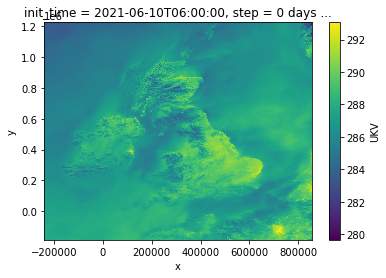

In [10]:
get_nwp_data(START_TIME, variable="t").plot();

In [11]:
nwp_min = nwp_dataset.sel(init_time=slice(START_TIME, END_TIME))["UKV"].min(dim=["x", "y", "init_time", "step"])
nwp_max = nwp_dataset.sel(init_time=slice(START_TIME, END_TIME))["UKV"].max(dim=["x", "y", "init_time", "step"])
nwp_min, nwp_max = dask.compute(nwp_min, nwp_max)

## Open and prepare GSP PV data

In [15]:
gsp_pv_dataset = xr.open_dataset(GSP_PV_PATH, engine="zarr").sel(datetime_gmt=slice(START_TIME, END_TIME))

In [16]:
gsp_pv_df = (gsp_pv_dataset["generation_mw"] / gsp_pv_dataset["installedcapacity_mwp"]).to_pandas()

In [17]:
gsp_metadata = pd.read_csv(GSP_METADATA, usecols=["gsp_id", "region_id"]).dropna().astype(int).set_index("region_id")

In [18]:
gsp_shape = gpd.read_file(GSP_SHAPE)

In [19]:
gsp_shape = gsp_shape.join(gsp_metadata, on="RegionID").set_index("gsp_id")

In [20]:
gsp_shape = gsp_shape.geometry

In [21]:
# Four GSP IDs have multiple shapes. Merge those shapes
duplicated_gsp_ids = gsp_shape.index[gsp_shape.index.duplicated()]
for duplicated_gsp_id in duplicated_gsp_ids:
    unary_union = gsp_shape.loc[duplicated_gsp_id].unary_union
    gsp_shape.drop(duplicated_gsp_id, inplace=True)
    gsp_shape.loc[duplicated_gsp_id] = unary_union
    
assert not gsp_shape.index.duplicated().any()

/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


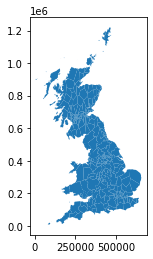

In [22]:
gsp_shape.plot();

In [23]:
gsp_shape = gsp_shape[gsp_pv_df.columns]
gsp_shape

gsp_id
1      POLYGON ((487588.011 199546.288, 487595.132 19...
2      POLYGON ((496184.317 245725.992, 496123.631 24...
3      POLYGON ((444809.038 322857.985, 445184.574 32...
4      POLYGON ((474705.047 330704.521, 475706.249 32...
5      MULTIPOLYGON (((456985.595 342513.345, 457193....
                             ...                        
334    POLYGON ((431103.209 173178.693, 429491.981 16...
335    POLYGON ((457669.188 490340.135, 459083.009 48...
336    MULTIPOLYGON (((227890.259 342451.377, 219808....
337    POLYGON ((263491.279 662342.918, 263144.468 66...
338    POLYGON ((257706.088 668038.056, 257540.903 66...
Name: geometry, Length: 338, dtype: geometry

In [25]:
assert np.all(gsp_pv_df.columns == gsp_shape.index)

## Open and prepare PV data

In [26]:
pv_dataset = xr.open_dataset(PV_PATH / "passiv.netcdf")

In [27]:
pv_dataset = pv_dataset.sel(datetime=slice(START_TIME, END_TIME))

In [28]:
pv_data_array = pv_dataset.to_array(dim="pv_system_id")

In [29]:
pv_df = pv_data_array.T.to_pandas()

In [30]:
del pv_dataset, pv_data_array

In [31]:
pv_df = pv_df.dropna(axis='columns', how='all')

In [32]:
pv_df.columns = pv_df.columns.astype(int)

In [33]:
pv_metadata = pd.read_csv(PV_PATH / "system_metadata.csv", index_col="system_id", usecols=["system_id", "latitude", "longitude"])

In [34]:
pv_metadata = pv_metadata.loc[pv_df.columns]

In [35]:
pv_df = pv_df / pv_df.max()

<AxesSubplot:xlabel='datetime'>

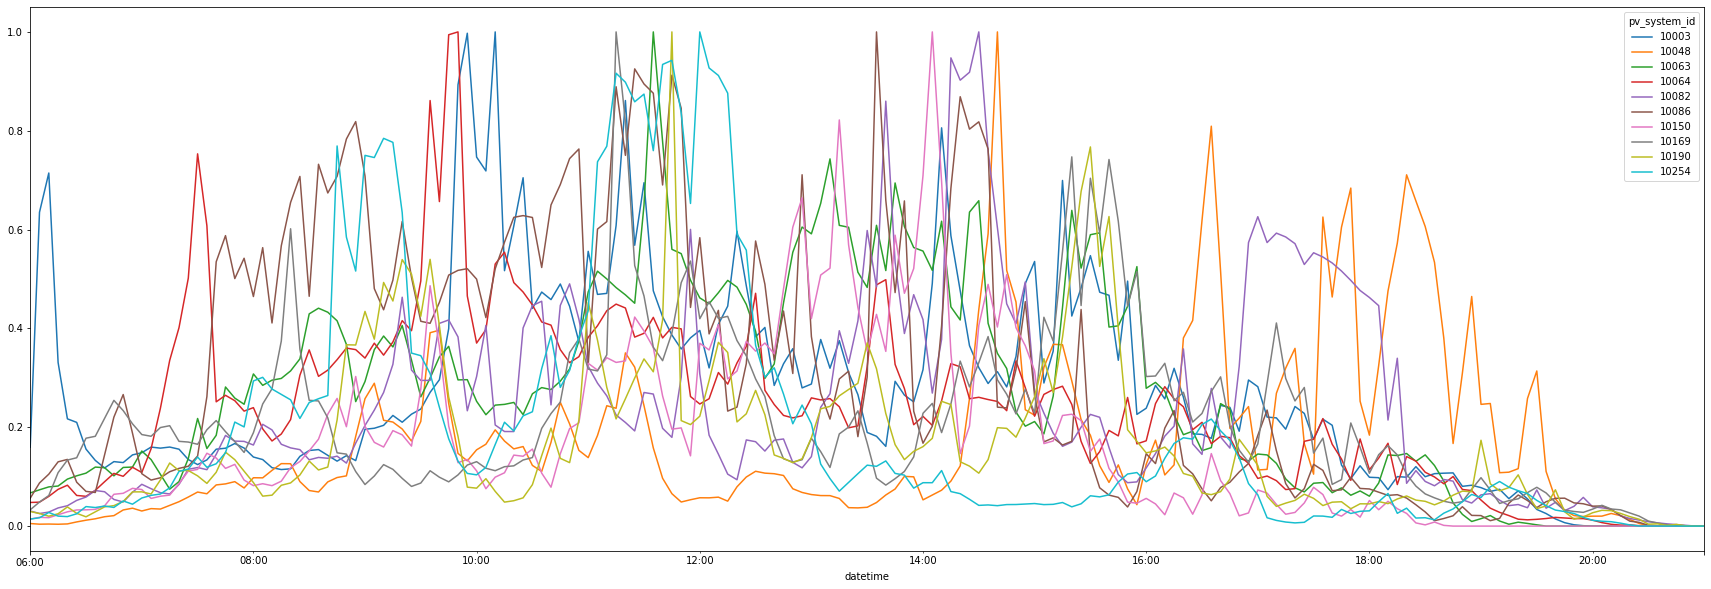

In [36]:
pv_df.iloc[:, 0:10].plot(figsize=(30, 10))

## Animate!

```

########### ########### ########### ########### 
#  nwp    # #   sat & # #   GSP   # #  ESO PV # 
#  dswrf  # #    PV   # #    PV   # # FCST ERR# 
########### ########### ########### ########### 

###############################################
#   price, freq, demand                       #
###############################################

```

In [37]:
def get_pv_colors_for_datetime(dt, df, cmap=cm.get_cmap('plasma')) -> np.ndarray:
    colors = df.loc[dt]
    colors = np.ma.masked_array(colors, mask=colors.isna())
    return cmap(colors)

In [38]:
def plot_gsp_power_heatmap(ax, dt):
    dt = pd.Timestamp(dt)
    gsp_shape_with_values = gsp_shape.to_frame()
    gsp_shape_with_values["power"] = gsp_pv_df.loc[dt.ceil("30T")]
    gsp_shape_with_values.plot(
        column="power",
        ax=ax,
        transform=ccrs.OSGB(approx=False),
        cmap="plasma",
        vmin=0,
        vmax=1,
    )
    ax.set_title("GSP PV (from Sheffield Solar)")

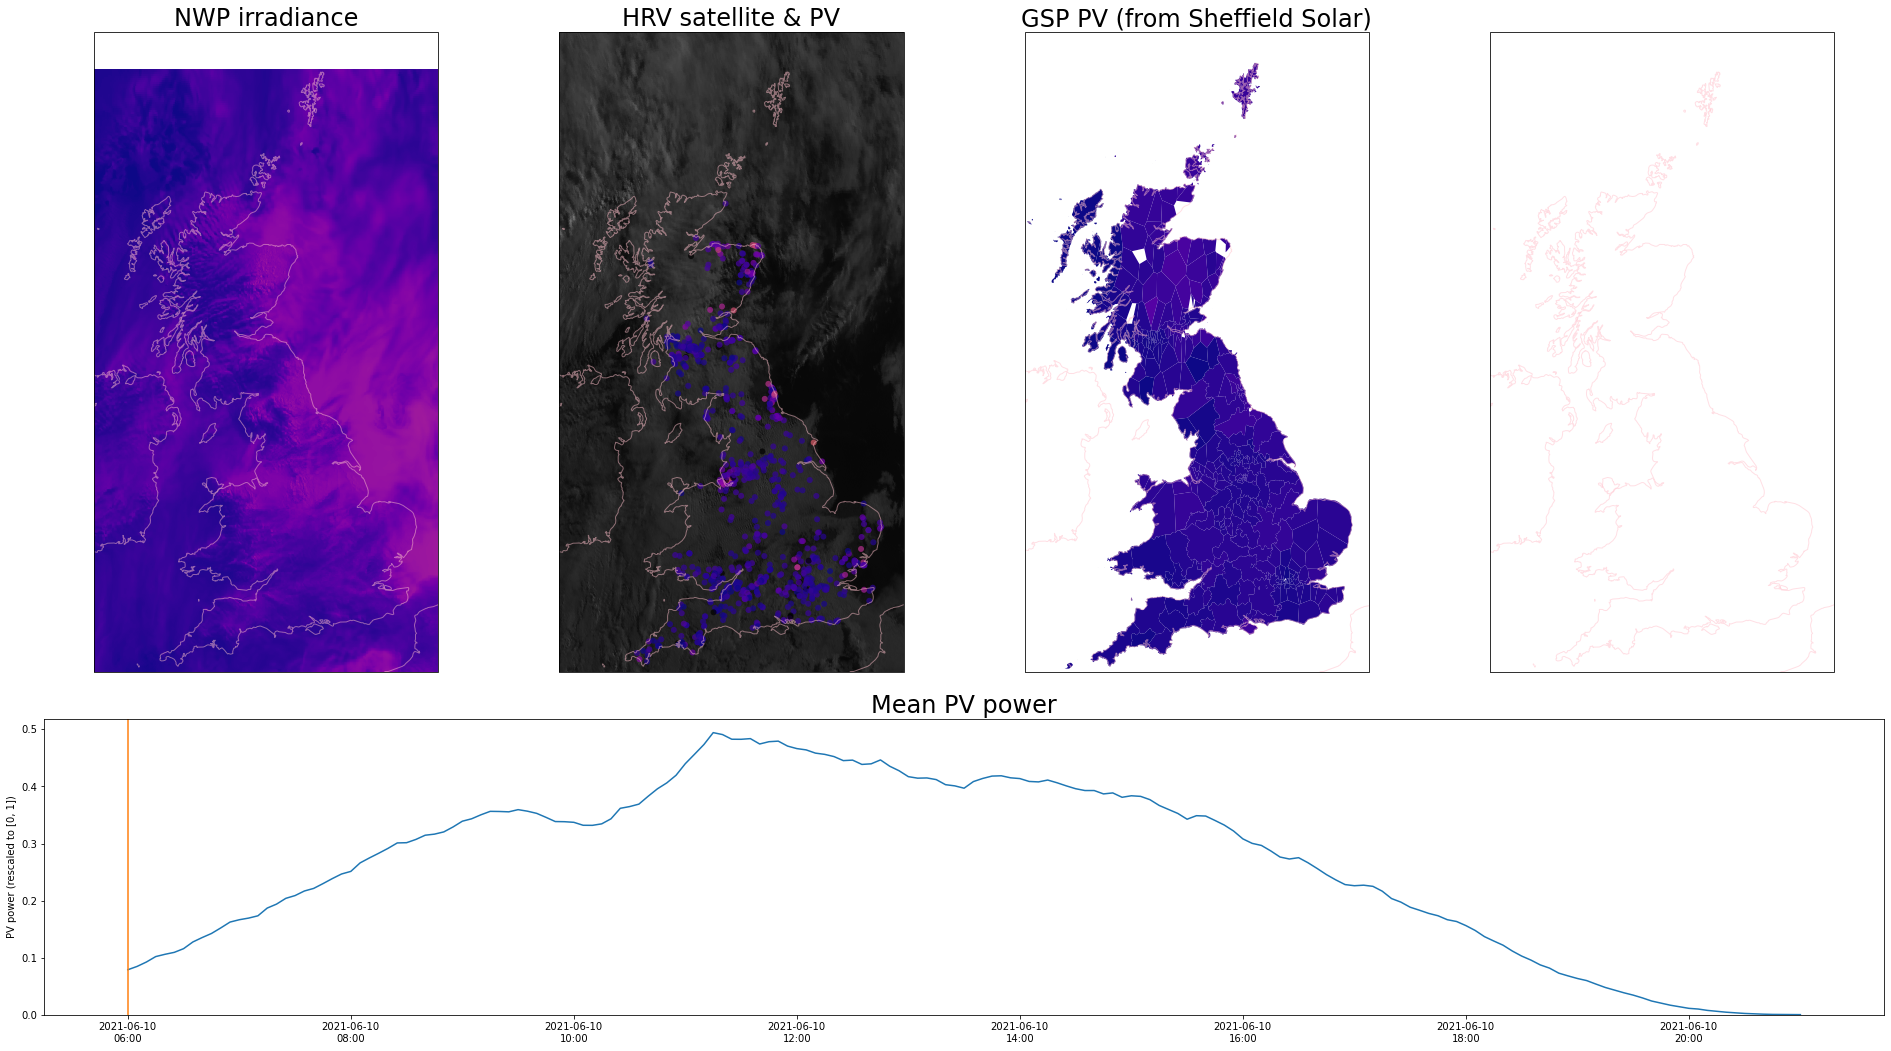

In [45]:
# SET UP THE FIGURE
# Spatial layout
NROWS = 3
NCOLS = 4
SHAPE = (NROWS, NCOLS)
dpi = plt.rcParams['figure.dpi']
fig = plt.figure(figsize=(1920/dpi, 1080/dpi))
projection = ccrs.OSGB(approx=False)
geospatial_plot_kwargs = dict(projection=projection, rowspan=2)
nwp_ax = plt.subplot2grid(SHAPE, loc=(0, 0), **geospatial_plot_kwargs)
sat_and_pv_ax = plt.subplot2grid(shape=SHAPE, loc=(0, 1), **geospatial_plot_kwargs)
gsp_ax = plt.subplot2grid(SHAPE, loc=(0, 2), **geospatial_plot_kwargs)
fcst_err_ax = plt.subplot2grid(SHAPE, loc=(0, 3), **geospatial_plot_kwargs)
timeseries_ax = plt.subplot2grid(SHAPE, loc=(2, 0), colspan=NCOLS)
fig.subplots_adjust(left=0.03, bottom=0.03, right=0.99, top=0.99, wspace=None, hspace=None)
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels

# Colours
#fig.patch.set_facecolor('black')
#sat_and_pv_ax.set_facecolor('black')

## SATELLITE ####################################################
# Plot first frame of satellite data
sat_img = selected_sat_dataset.isel(time=0).plot.pcolormesh(
    ax=sat_and_pv_ax,
    transform=ccrs.Geostationary(central_longitude=9.5),
    x="x",
    y="y",
    add_colorbar=False,
    cmap="gray",
    vmin=min_satellite_value.data,
    vmax=max_satellite_value.data,
)

## PV ###########################################################
pv_scatter = sat_and_pv_ax.scatter(
    x=pv_metadata.longitude,
    y=pv_metadata.latitude,
    alpha=0.7,
    linewidth=0,
    transform=ccrs.PlateCarree(),
)
pv_scatter.set_color(get_pv_colors_for_datetime(START_TIME, df=pv_df))
sat_and_pv_ax.set_title("HRV satellite & PV")

## NWP #########################################################
selected_nwp_data = get_nwp_data(START_TIME, variable="dswrf")
nwp_img = selected_nwp_data.plot.pcolormesh(
    ax=nwp_ax,
    transform=ccrs.OSGB(approx=False),
    add_colorbar=False,
    cmap="plasma",
    vmin=nwp_min.sel(variable="dswrf").values,
    vmax=nwp_max.sel(variable="dswrf").values,
)
nwp_ax.set_title("NWP irradiance")
nwp_ax.set_ylim(sat_and_pv_ax.get_ylim())
nwp_ax.set_xlim(sat_and_pv_ax.get_xlim())

## GSP ######################################################
plot_gsp_power_heatmap(ax=gsp_ax, dt=START_TIME)

## FORMAT GEO PLOTS #########################################
for ax in [nwp_ax, sat_and_pv_ax, gsp_ax, fcst_err_ax]:
    ax.coastlines(resolution='10m', alpha=0.5, color='pink')

## TIMESERIES PLOT ##########################################
timeseries_ax.plot(pv_df.mean(axis='columns'))
timeseries_ax.set_title("Mean PV power")
timeseries_ax.set_ylabel("PV power (rescaled to [0, 1])")
timeseries_ax.set_ylim(0, timeseries_ax.get_ylim()[1])
timeseries_ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))

time_marker = timeseries_ax.plot(
    (sat_datetime_index[0], sat_datetime_index[0]),
    timeseries_ax.get_ylim(),
)[0]

plt.tight_layout()

In [40]:
# Animation function
def update(i: int = 0):
    # Satellite
    new_sat_data = selected_sat_dataset.isel(time=i)
    sat_img.set_array(new_sat_data.values.ravel())
    dt = pd.Timestamp(new_sat_data.time.values)
    
    # NWP
    new_nwp_data = get_nwp_data(dt, variable="dswrf")
    nwp_img.set_array(new_nwp_data.values.ravel())
    
    # PV
    pv_scatter.set_color(get_pv_colors_for_datetime(dt, df=pv_df))
    
    # GSP PV
    # We can't use set_array or set_color, unfortunately, because the
    # ordering of the patches gets muddled.
    gsp_ax.clear()
    plot_gsp_power_heatmap(ax=gsp_ax, dt=dt)
    
    # Time marker
    time_marker.set_xdata((sat_datetime_index[i], sat_datetime_index[i]))
    return sat_img, time_marker

anim = FuncAnimation(fig, update, frames=range(0, len(sat_datetime_index), 1), interval=80, blit=True)
video = anim.to_html5_video()
display.HTML(video)


KeyboardInterrupt



<Figure size 432x288 with 0 Axes>

TODO:

* Black background?
* Timeseries plot:
  * Format datetimes
  * title
  * y-axis label
* Larger text?
* Output to file